<a href="https://colab.research.google.com/github/nyangwara/Geometric-Tortuosity-calculation-in-Porous-Media/blob/main/tortuosity_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/seung-lab/euclidean-distance-transform-3d/
https://stackoverflow.com/questions/30802269/merging-2d-slices-into-3d-volume-in-python

https://pydicom.github.io/pydicom/dev/auto_examples/image_processing/reslice.html



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install edt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 22.2 MB/s 


In [ ]:
from pathlib import Path
some_path=''
p = Path(some_path)
p.rename(Path(p.parent, f"{p.stem}_1_{p.suffix}"))




*os.rename('a.txt', 'b.kml')
*old_file = os.path.join("directory", "a.txt") 
*new_file = os.path.join("directory", "b.kml")
*os.rename(old_file, new_file)



In [ ]:
import numpy as np
import os
import glob
import cv2
import edt

allowable_extensions = ['.png', '.tif', '.tiff', '.bmp', '.dib', '.jpg', '.jpeg']

def get_index_from_file_name(path_name):
    ''' return index from path_name
        e.g. for image0001 index is 1
     '''
    file_name = path_splitted = os.path.split(path_name)[-1]
    file_name = os.path.splitext(file_name)[0]
    i = len(file_name) - 1
    while(file_name[i].isdigit()== True and i >= 0 ):
        i -= 1
    if i == len(file_name) - 1: # there are no any digits
        return -1
    return int(file_name[i+1:])

def read_slices(path_to_first_slice):

    # check correctness of type of input parameter
    if not isinstance(path_to_first_slice, str):
        raise TypeError('Parameter path_to_first_slice has to be string!')

    path_splitted = os.path.split(path_to_first_slice)
    first_slice_file_name = path_splitted[-1]
    filename_splitted = os.path.splitext(first_slice_file_name)
    first_slice_extension = filename_splitted[-1]
    if not first_slice_extension in allowable_extensions:
        raise ValueError(first_slice_file_name + ' is unsupported file format!')
    # open first slice
    slice1 = cv2.imread(path_to_first_slice, cv2.IMREAD_ANYDEPTH)
    if slice1 is None:
        raise ValueError('OpenCV reading error for : ' + path_to_first_slice)
    # check dimensions and bit depth
    if slice1.ndim != 2:
        raise ValueError(path_to_first_slice + ' must be grayscale 2D image')
    if slice1.dtype != np.uint8: # and slice1.dtype != np.uint16:
        raise ValueError(path_to_first_slice + ' has wrong bit depth.')

    # forming of template for file names of slices
    template_name = filename_splitted[0]
    # trim digits on end of filename and calculate number of digits
    digits_len = 0
    while (len(template_name) > 0 and template_name[-1].isdigit() == True):
        template_name = template_name[:-1]
        digits_len += 1
    # checking of digits in the end of file name
    if digits_len < 3:
        raise ValueError('Incorrect name of first slice, 4 or more digits should be in the end of file name: ' + first_slice_file_name)
    search_template = '%s' % template_name # string copying via formatting
    for i in range(0, digits_len):
        search_template += "?"
    # looking for maximal index of slice
    files_list = glob.glob(os.path.join(path_splitted[0], search_template + first_slice_extension))
    max_slice_index = 0
    for file_name in files_list:
        slice_index = get_index_from_file_name(file_name)
        if slice_index > max_slice_index:
            max_slice_index = slice_index

    first_slice_index = int(filename_splitted[0][-digits_len:])
    template_name = os.path.join(path_splitted[0], template_name + "{0:0" + str(digits_len) + "}" +
                                 first_slice_extension)

    # memory allocation for image
    i3d = np.zeros((max_slice_index - first_slice_index + 1,) + slice1.shape, dtype=slice1.dtype)
    i3d[0] = slice1
    # loop through all indexes
    k = 1
    for i in range(first_slice_index + 1, max_slice_index + 1):
        i3d[k] = cv2.imread(template_name.format(i), cv2.IMREAD_ANYDEPTH)
        k += 1

    return i3d



In [ ]:
img=read_slices("/content/drive/MyDrive/Model300/im_000.png")
img.shape

(300, 300, 300)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img[0,:,:], cmap = plt.cm.gray), plt.axis('off')
plt.show()

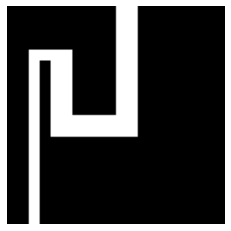

In [ ]:
#test image

img = np.zeros((100,100),np.uint8)
img[:50,50:60] = 255
img[50:60,20:60] = 255
img[20:50,20:30] = 255
img[20:25,10:20] = 255
img[25:,10:15] = 255

mask = img == 255


import matplotlib.pyplot as plt
plt.imshow(mask, cmap = plt.cm.gray), plt.axis('off')
plt.show()

In [ ]:

def geodesic_distance_bf(mask, seed):
    gd = np.zeros(seed.shape, np.int32)

    seeds = seed
    prev_sum = np.sum(seeds)
    while (True):
        dt = edt.edt(np.logical_not(seeds), parallel=0)
        layer = np.logical_and(dt <= 1, mask)
        seeds = np.logical_or(seeds, layer)
        cur_sum = np.sum(seeds)
        gd += seeds
        if cur_sum == prev_sum:
            break
        prev_sum = cur_sum

    gd = np.max(gd) * np.ones(gd.shape, np.int32) - gd
    return gd


seeds = np.zeros((mask.shape), np.uint8)
seeds[0, :] = 1
seeds = np.logical_and(seeds, mask)

gd = geodesic_distance_bf(mask, seeds)

plt.imshow(gd, cmap=plt.cm.gray), plt.axis('off')
plt.show()
print("tortuosity =", gd.shape[0] / np.min(gd[-1, :]))

In [ ]:
def chamfer_distance(img):
   w, h = img.shape
   dt = mask
   # Forward pass
   x = 0
   y = 0
   if img[x,y] == 0:
      dt[x,y] = 65535 # some large value
   for x in range(1, w):
      if img[x,y] == 0:
         dt[x,y] = 3 + dt[x-1,y]
   for y in range(1, h):
      x = 0
      if img[x,y] == 0:
         dt[x,y] = min(3 + dt[x,y-1], 4 + dt[x+1,y-1])
      for x in range(1, w-1):
         if img[x,y] == 0:
            dt[x,y] = min(4 + dt[x-1,y-1], 3 + dt[x,y-1], 4 + dt[x+1,y-1], 3 + dt[x-1,y])
      x = w-1
      if img[x,y] == 0:
         dt[x,y] = min(4 + dt[x-1,y-1], 3 + dt[x,y-1], 3 + dt[x-1,y])
   # Backward pass
   for x in range(w-2, -1, -1):
      y = h-1
      if img[x,y] == 0:
         dt[x,y] = min(dt[x,y], 3 + dt[x+1,y])
   for y in range(h-2, -1, -1):
      x = w-1
      if img[x,y] == 0:
         dt[x,y] = min(dt[x,y], 3 + dt[x,y+1], 4 + dt[x-1,y+1])
      for x in range(1, w-1):
         if img[x,y] == 0:
            dt[x,y] = min(dt[x,y], 4 + dt[x+1,y+1], 3 + dt[x,y+1], 4 + dt[x-1,y+1], 3 + dt[x+1,y])
      x = 0
      if img[x,y] == 0:
         dt[x,y] = min(dt[x,y], 4 + dt[x+1,y+1], 3 + dt[x,y+1], 3 + dt[x+1,y])
   return dt

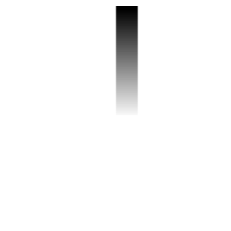

tortuosity = 2.0


In [ ]:
seeds = np.zeros((mask.shape), np.uint8)
seeds[0, :] = 1
seeds = np.logical_and(seeds, mask)
gd = geodesic_distance_bf(mask, seeds)
gd=chamfer_distance(img)
plt.imshow(gd, cmap=plt.cm.gray), plt.axis('off')
plt.show()
print("tortuosity =", gd.shape[0] / np.min(gd[-1, :]))

https://stackoverflow.com/questions/53678520/speed-up-computation-for-distance-transform-on-image-in-python

In [ ]:
import numpy as np
A=np.zeros((10,11,11),int)
for i in range(0,5):
    j=i+1
    A[i, j:-j, j:-j] = i

4
